En este notebook, se hacen los calculos necesarios para sacar métricas de evaluación de las recomendaciones tanto de researchers como de calls.

versión: 22-03-2024  
autores: Marta Almagro y Marta Balairón

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from funciones_recommendation_system import get_datasets, match_researcher_call, recommendation_system_researcher_call, match_call_researcher, recommendation_system_call_researcher

# 1. Load datasets and Similarity matrices

In [2]:
# load databases
path = '/export/data_ml4ds/AI4U/Datasets/'
version_wp = '20240510'
version_rp = '20240321'
df_publications, df_projects, df_publications_researchers,df_projects_researchers, df_researchers, df_calls = get_datasets(path, version_wp, version_rp)

# load the validation set
df_val = pd.read_excel('/export/usuarios_ml4ds/mafuello/Github/recommendation_system_validation/validation_set.xlsx')
df_val = df_val.rename(columns={'research portal': 'invID'})
df_val = df_val.rename(columns={'invID': 'id_RP'}).merge(df_researchers[['id_RP', 'id_researcher']], on='id_RP')

/home/mbalairon/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [29]:
invID = df_val['id_researcher'][0]

In [55]:
invID

1211

In [31]:
df_researchers[df_researchers['id_researcher']==invID].reset_index()['Name'][0]

'Cavallaro, Rauno'

In [49]:
call = df_val['Línea prioritia/panel/topic'][0]

In [41]:
ranking = recommendation_system_call_researcher(method='BERT', agg_method='mean', call='HORIZON-CL5-2023-D5-01-09', researchers=df_researchers)

In [42]:
 ranking.shape[0]

1227

In [44]:
indice_valor_exacto = ranking.loc[ranking['id_researcher'] == invID].index[0]
ranking = ranking.iloc[:indice_valor_exacto + 1]
posicion = ranking.shape[0]

In [46]:
posicion = ranking.shape[0]
max_similarity = ranking['similarity'][0]
similarity = ranking['similarity'][posicion-1]

In [50]:
acronimo = df_val['Acrónimo'][0]
department = df_researchers[df_researchers['id_researcher']==invID].reset_index()['Department'][0]
cluster = df_calls[df_calls['Call']==call].reset_index()['Work Programme'][0]


In [52]:
target = 'id_researcher'
if posicion == 1:
    first_recommendations = ''
elif posicion>5:
    first_recommendations = ranking[target].head(5).tolist()
    first_recommendations = '; '.join(first_recommendations)
else:
    first_recommendations = ranking[target].tolist()
    first_recommendations.pop()   
    first_recommendations = '; '.join(first_recommendations)

TypeError: sequence item 0: expected str instance, int found

In [57]:
ranking['Name'].head(5)

#.tolist()

0      Guerra Sancho, Antonio
1    Cimadevilla Diez, Adrian
2          Lachowski, Dariusz
3            Modesti, Alberto
4        San, Bun-Kim Nicolas
Name: Name, dtype: object

# 2. Obtain Recommendations

In [58]:
def get_validation_results(df_val, df_researchers, df_calls, method, agg_method, recommendations):
    '''
    Función para calcular las métricas de similitud además de preparar el dataset para el SI.
    Se obtienen scores para las recomendacions de calls para un investigador dado
    
    df_val -> DataFrame con las propuestas de validación del SI (lo que han solicitado de verdad los investigadores)
    df_researchers -> DataSet con todos los datos relativos a los investigadores
    df_calls -> DataSet con todos los datos relativos a las convocatorias
    method -> Method selected to calculate the similarities 
    agg_method -> Agregation method selected for calculating the similarties between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    
    '''
    
    new_rows  = []
    errores = []
    total_iterations = df_val.shape[0]
    for i in tqdm(range(total_iterations), desc="Processing", unit=" rows", ncols=100):
        invID = df_val['id_researcher'][i]
        name = df_researchers[df_researchers['id_researcher']==invID].reset_index()['Name'][0]
        call = df_val['Línea prioritia/panel/topic'][i]

        try:
            # in case we look for recommendations of calls given a researcher
            if recommendations == 'calls':                 
                # get the recommendations 
                ranking = recommendation_system_researcher_call(method=method, agg_method=agg_method, researcher=invID, calls=df_calls)
                total_recommendations = ranking.shape[0]
                indice_valor_exacto = ranking.loc[ranking['Call'] == call].index[0]
                ranking = ranking.iloc[:indice_valor_exacto + 1]
                target = 'Call' # para luego buscar la variable

            # in case we look for recommendations of researchers given a call
            if recommendations == 'researchers': 
                # get the recommendations 
                ranking = recommendation_system_call_researcher(method=method, agg_method=agg_method, call=call, researchers=df_researchers)
                total_recommendations = ranking.shape[0]
                indice_valor_exacto = ranking.loc[ranking['id_researcher'] == invID].index[0]
                ranking = ranking.iloc[:indice_valor_exacto + 1]
                posicion = ranking.shape[0]
                target = 'id_researcher' # para luego buscar la variable

            posicion = ranking.shape[0]
            max_similarity = ranking['similarity'][0]
            similarity = ranking['similarity'][posicion-1]

            # obtain the necessary metadata SI
            acronimo = df_val['Acrónimo'][i]
            department = df_researchers[df_researchers['id_researcher']==invID].reset_index()['Department'][0]
            cluster = df_calls[df_calls['Call']==call].reset_index()['Work Programme'][0]

            if posicion == 1:
                first_recommendations = ''
            elif posicion>5:
                first_recommendations = ranking['Name'].head(5).tolist()
                first_recommendations = '; '.join(first_recommendations)
            else:
                first_recommendations = ranking['Name'].tolist()
                first_recommendations.pop()   
                first_recommendations = '; '.join(first_recommendations)

            # compute score based on similarity
            score_similarity = 1 - ((max_similarity - similarity)/max_similarity)    

            # compute score based on position
            if similarity == 0: 
                score_posicion = 0 
            else:
                score_posicion = 1 - ((posicion-1) / total_recommendations)

            # compute score based on the cluster or department
            if recommendations == 'calls':
                cluster_correcto = ranking['Work Programme'][posicion-1]
                count_cluster_correctos = 0
                for i in range(ranking.shape[0]):
                    if ranking['Work Programme'][i] == cluster_correcto:
                        count_cluster_correctos += 1

                score_cluster = count_cluster_correctos/ranking.shape[0]
                target_col = 'cluster' # para luego nombrar la columna

            if recommendations == 'researchers':
                department_correcto = ranking['Department'][posicion-1]
                count_department_correctos = 0
                for i in range(ranking.shape[0]):
                    if ranking['Department'][i] == department_correcto:
                        count_department_correctos += 1

                score_cluster = count_department_correctos/ranking.shape[0] 
                target_col = 'department' # para luego nombrar la columna
            
            # detect change of cluster in the recommendations
            distinct_clusters = []
            if recommendations == 'calls':
                if ranking.shape[0] > 10:
                    for i in range(10):
                        if ranking['Work Programme'][i] != cluster_correcto:
                            distinct_clusters.append(ranking['Call'][i])
                else:
                    for i in range(ranking.shape[0]):
                        if ranking['Work Programme'][i] != cluster_correcto:
                            distinct_clusters.append(ranking['Call'][i])

                if len(distinct_clusters) > 3:
                    distinct_clusters = distinct_clusters[:3]

                distinct_clusters = '; '.join(distinct_clusters)
                
            # añadir la fila a la lista de diccionarios
            score = (score_cluster + score_posicion + score_similarity)/3
            new_rows.append({'Nombre': name,
                             'Topic': call,
                             'Acrónimo': acronimo,
                             'Departamento': department,
                             'Cluster': cluster,
                             'Posición': posicion,
                             'Similitud': similarity,
                             'Método_Recomendación': method + '_' + agg_method,
                             'Primeras_Recomendaciones':  first_recommendations,
                             'Primeras_Recomendaciones_Clusters_Distintos': distinct_clusters,
                             'Recomendando': recommendations,
                             'score_posicion': score_posicion,
                             'score_similitud': score_similarity,
                             'score_{}'.format(target_col): score_cluster,
                             'score': score})

        except Exception as e:
            errores.append([invID, call, str(e)])
            
    # crear un nuevo DataFrame con las filas añadidas
    df_validation_results = pd.DataFrame(new_rows).sort_values(by='score', ascending=False).fillna(0)
    # df_validation_results = pd.DataFrame(new_rows).fillna(0)
    
    return df_validation_results, errores


In [59]:
def get_df_results(d):
    '''
    Función para unificar todos los datasest de un diccionario
    
    d -> Diccionario con todos los datasets a unificar
    '''
    dfs = []
    for key, df in d.items():
        # Agregar el DataFrame a la lista
        dfs.append(df)
        
    df_result = pd.concat(dfs, ignore_index=True).sort_values(by = 'score', ascending = False).fillna(0)

    return df_result

In [60]:
methods = ['BERT', 'tfidf', 'bhattacharyya', 'embeddings']
agg_methods = ['sum', 'mean', 'mean_imp'] 

#methods = ['BERT', 'bhattacharyya']
#methods = ['BERT']
#agg_methods = ['mean_imp'] 
val_results_researchers = {}
val_results_calls = {}


# compute scores for recomendations of calls for a given researcher
for i in methods:
    for j in agg_methods:
        val_results_researchers[f"{i}_{j}_val_results"], errores = get_validation_results(df_val=df_val, df_researchers=df_researchers, df_calls=df_calls, method=i, agg_method=j, recommendations='researchers')      
        val_results_calls[f"{i}_{j}_val_results"], errores = get_validation_results(df_val=df_val, df_researchers=df_researchers, df_calls=df_calls, method=i, agg_method=j, recommendations='calls')

# Unificar todos los dataframes
df_val_researchers = get_df_results(val_results_researchers)
df_val_calls = get_df_results(val_results_calls)



Processing: 100%|████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.94 rows/s]


In [81]:
mapeo = {'BERT_mean_imp': 'Basado en palabras', 'bhattacharyya_mean_imp': 'Basado en modelo de tópicos'}

#df_val_researchers['Método_Recomendación'] = df_val_researchers['Método_Recomendación'].replace(mapeo)
df_val_calls['Método_Recomendación'] = df_val_calls['Método_Recomendación'].replace(mapeo)

In [65]:
df_val_calls.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system_validation/df_val_calls_2024.parquet')

In [85]:
#df_val_calls.to_csv('validation_recommendations_calls.csv', sep=',', decimal='.')
#df_val_calls.to_excel('validation_recommendations_calls.xlsx')
#df_val_researchers.to_csv('validation_recommendations_researchers.csv')

# 3. Get Comparison Plots

### Historgram

In [109]:
def get_sim_matrix_score(method, agg_method, recommendations, path='/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_{}_{}.parquet'):
    '''
    Function for computing the similarity matrix scores depending if we are recommendating calls or researchers
    
    method -> Method selected to calculate the similarities 
    agg_method -> Agregation method selected for calculating the similarties between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    path -> Path to the file containing the similarity matrix. Important to have the similarity matrices stored as similarity_method_aggMethod.parquet
    '''
    sim_matrix = pd.read_parquet(path.format(method, agg_method)).fillna(0)
    
    df_similarity_scores = pd.DataFrame(columns=sim_matrix.columns, index=sim_matrix.index)

    if recommendations == 'calls':
        tqdm.pandas()

        for index, row in tqdm(sim_matrix.iterrows(), total=len(sim_matrix), desc="Calculando similitud"):
            sort_row = row.sort_values(ascending=False)
            max_similarity = sort_row.head(1)[0]

            score_row = []

            for similarity in row:
                score_similarity = 1 - ((max_similarity - similarity)/max_similarity) 
                score_row.append(score_similarity)

            df_similarity_scores.loc[index] = score_row
    
    if recommendations == 'researchers':
        tqdm.pandas()

        for col_index in tqdm(sim_matrix.columns, total=len(sim_matrix.columns), desc="Calculando similitud"):
            sorted_col = sim_matrix[col_index].sort_values(ascending=False)
            max_similarity = sorted_col.head(1).reset_index()[col_index][0]

            score_col = []
            for similarity in sim_matrix[col_index]:
                score_similarity = 1 - ((max_similarity - similarity)/max_similarity) 
                score_col.append(score_similarity)

            df_similarity_scores[col_index] = score_col

            
    return df_similarity_scores

In [110]:
def get_plot_scores_analysis(df_all_scores, df_validation, method, agg_method, recommendations, save=False, path=None):
    '''
    Function for obtaining the plot for analysing the similarity scores for a given method and agg_method
    
    method -> Method selected to calculate the similarities 
    agg_method -> Agregation method selected for calculating the similarties between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    save -> Boolean for indicating if we want to save the plot
    path -> saving path
    '''
    
    values = df_all_scores.values.flatten()
    highlight_values = df_validation['score_similitud']
    
    # Crear el histograma para todos los valores
    n, bins, patches = plt.hist(values, bins=100, color='blue', label='All Recommendations', edgecolor='black')
    
    # Cambiar el color de las barras resaltadas
    for patch in patches:
        for val in highlight_values:
            if patch.get_x() < val < patch.get_x() + patch.get_width():
                patch.set_facecolor('red')
                break

    plt.xlabel('Similarity Score')
    plt.ylabel('Frecuency')
    plt.title('Analysis of {} recommendations computed with {} and aggregated by {}.'.format(recommendations, method, agg_method ))
    plt.grid(True)
    plt.tight_layout()
    
    # Leyenda para indicar las recomendaciones validadas
    legend_elements = [
        plt.Rectangle((0,0),1,1,color='blue', label='All Recommendations'),
        plt.Rectangle((0,0),1,1,color='red', label='Validated Recommendations')
    ]
    plt.legend(handles=legend_elements)

    if save:
        plt.savefig(path)
    
    plt.show()

In [111]:
def get_plot_scores_analysis_multiple(ax, df_all_scores, df_validation, method, agg_method, recommendations, save=False, path=None):
    '''
    Function for obtaining the plot for analysing the similarity scores comparing different aggregation methods
    
    method -> Method selected to calculate the similarities 
    agg_method -> Agregation method selected for calculating the similarties between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    save -> Boolean for indicating if we want to save the plot
    path -> saving path
    '''
    
    values = df_all_scores.values.flatten()
    highlight_values = df_validation['score_similitud']
    
    # Crear el histograma para todos los valores
    n, bins, patches = ax.hist(values, bins=50, color='blue', label='All Recommendations', edgecolor='black')
    
    # Cambiar el color de las barras resaltadas
    for patch in patches:
        for val in highlight_values:
            if patch.get_x() < val < patch.get_x() + patch.get_width():
                patch.set_facecolor('red')
                break

    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Frequency')
    ax.set_title('{}_{}.'.format(method, agg_method))
    ax.grid(True)
    
    # Leyenda para indicar las recomendaciones validadas
    legend_elements = [
        plt.Rectangle((0,0),1,1,color='blue', label='All Recommendations'),
        plt.Rectangle((0,0),1,1,color='red', label='Validated Recommendations')
    ]
    ax.legend(handles=legend_elements)

    if save:
        plt.savefig(path)


Calculando similitud:  96%|█████████▋| 1181/1227 [00:00<00:00, 1295.57it/s]/tmp/ipykernel_2972102/2165234701.py:24: RuntimeWarning: invalid value encountered in scalar divide
  score_similarity = 1 - ((max_similarity - similarity)/max_similarity)
Calculando similitud: 100%|██████████| 1227/1227 [00:00<00:00, 1298.40it/s]
/Server/python/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Server/python/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
Calculando similitud:  87%|████████▋ | 1068/1227 [00:00<00:00, 1330.32it/s]/tmp/ipykernel_2972102/2165234701.py:24: RuntimeWarning: invalid value encountered in scalar divide
  score_similarity = 1 - ((max_similarity - similarity)/max_similarity)
Calculando similitud: 100%|██████████| 1227/1227 [00:00<00:00, 1324.61it/s]
/Server/pyt

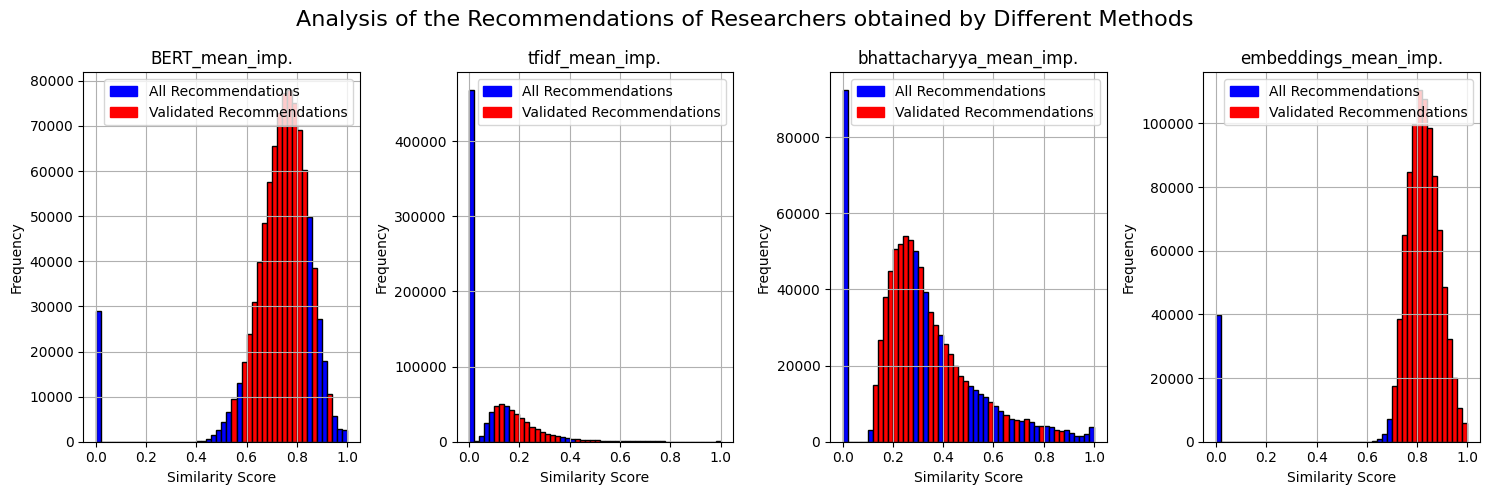

In [115]:
methods = ['BERT', 'tfidf', 'bhattacharyya', 'embeddings']
#agg_methods = ['sum', 'mean', 'mean_imp'] 
agg_method = 'mean_imp'
recommendations = 'calls'

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, method in enumerate(methods):
    df_validation = val_results_researchers[f"{method}_{agg_method}_val_results"]    
    df_all_scores = get_sim_matrix_score(method=method, agg_method=agg_method, recommendations=recommendations)
    get_plot_scores_analysis_multiple(axs[i], df_all_scores, df_validation, method=method, agg_method=agg_method, recommendations=recommendations)

plt.suptitle('Analysis of the Recommendations of Researchers obtained by Different Methods', fontsize=16)
plt.tight_layout()
plt.show()


### Boxplot

In [122]:
def plot_box_scores(df_all_scores, df_validation, method, agg_method, recommendations, save=False, path=None):
    '''
    Function for plotting box plots of similarity scores for all recommendations and validated recommendations
    
    df_all_scores -> DataFrame containing similarity scores for all recommendations
    df_validation -> DataFrame containing validation results
    method -> Method selected to calculate the similarities 
    agg_method -> Aggregation method selected for calculating the similarities between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    save -> Boolean for indicating if we want to save the plot
    path -> Saving path
    '''
    
    all_scores = df_all_scores.values.flatten()
    valid_scores = df_validation['score_similitud']
    
    plt.boxplot([all_scores, valid_scores], labels=['All Recommendations', 'Validated Recommendations'])
    
    plt.xlabel('Recommendations')
    plt.ylabel('Similarity Score')
    plt.title('Box Plot of Similarity Scores for {} Recommendations (Method: {}, Aggregation: {})'.format(recommendations, method, agg_method))
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)
    
    plt.show()

# Llama a la función para generar el box plot
#plot_box_scores(df_all_scores, df_validation, method, agg_method, recommendations)


In [123]:
def get_plot_scores_analysis_multiple(ax, df_all_scores, df_validation, method, agg_method, recommendations, save=False, path=None):
    '''
    Function for obtaining the plot for analysing the similarity scores comparing different aggregation methods
    
    ax -> Axes object to plot on
    df_all_scores -> DataFrame containing similarity scores for all recommendations
    df_validation -> DataFrame containing validation results
    method -> Method selected to calculate the similarities 
    agg_method -> Aggregation method selected for calculating the similarities between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    save -> Boolean for indicating if we want to save the plot
    path -> Saving path
    '''
    
    all_scores = df_all_scores.values.flatten()
    valid_scores = df_validation['score_similitud']
    
    ax.boxplot([all_scores, valid_scores], labels=['All', 'Validated'])
    
    ax.set_xlabel('Recommendations')
    ax.set_ylabel('Similarity Score')
    ax.set_title('{}_{}'.format(method, agg_method))
    ax.grid(True)

    if save:
        plt.savefig(path)

In [134]:
def get_sim_matrix_score(method, agg_method, recommendations, path='/export/usuarios_ml4ds/mbalairon/github/recommendation_system/similarity_matrices_researchers/similarity_{}_{}.parquet'):
    '''
    Function for computing the similarity matrix scores depending if we are recommending calls or researchers
    
    method -> Method selected to calculate the similarities 
    agg_method -> Aggregation method selected for calculating the similarities between calls and researchers
    recommendations -> Must be either researchers or calls. It indicates if we are looking for recommendations of researchers or calls
    path -> Path to the file containing the similarity matrix. Important to have the similarity matrices stored as similarity_method_aggMethod.parquet
    '''
    sim_matrix = pd.read_parquet(path.format(method, agg_method)).fillna(0)
    
    df_similarity_scores = pd.DataFrame(columns=sim_matrix.columns, index=sim_matrix.index)

    if recommendations == 'calls':
        tqdm.pandas()

        for index, row in tqdm(sim_matrix.iterrows(), total=len(sim_matrix), desc="Calculating similarity"):
            sort_row = row.sort_values(ascending=False)
            max_similarity = sort_row.head(1)[0]

            score_row = []

            if max_similarity != 0:
                for similarity in row:
                    score_similarity = 1 - ((max_similarity - similarity) / max_similarity) 
                    score_row.append(score_similarity)
            else:
                score_row = [0] * len(row)

            df_similarity_scores.loc[index] = score_row
    
    if recommendations == 'researchers':
        tqdm.pandas()

        for col_index in tqdm(sim_matrix.columns, total=len(sim_matrix.columns), desc="Calculating similarity"):
            sorted_col = sim_matrix[col_index].sort_values(ascending=False)
            max_similarity = sorted_col.head(1).reset_index()[col_index][0]

            score_col = []
            if max_similarity != 0:
                for similarity in sim_matrix[col_index]:
                    score_similarity = 1 - ((max_similarity - similarity) / max_similarity) 
                    score_col.append(score_similarity)
            else:
                score_col = [0] * len(sim_matrix[col_index])

            df_similarity_scores[col_index] = score_col
            
    return df_similarity_scores



Calculating similarity: 100%|██████████| 766/766 [00:01<00:00, 646.20it/s]


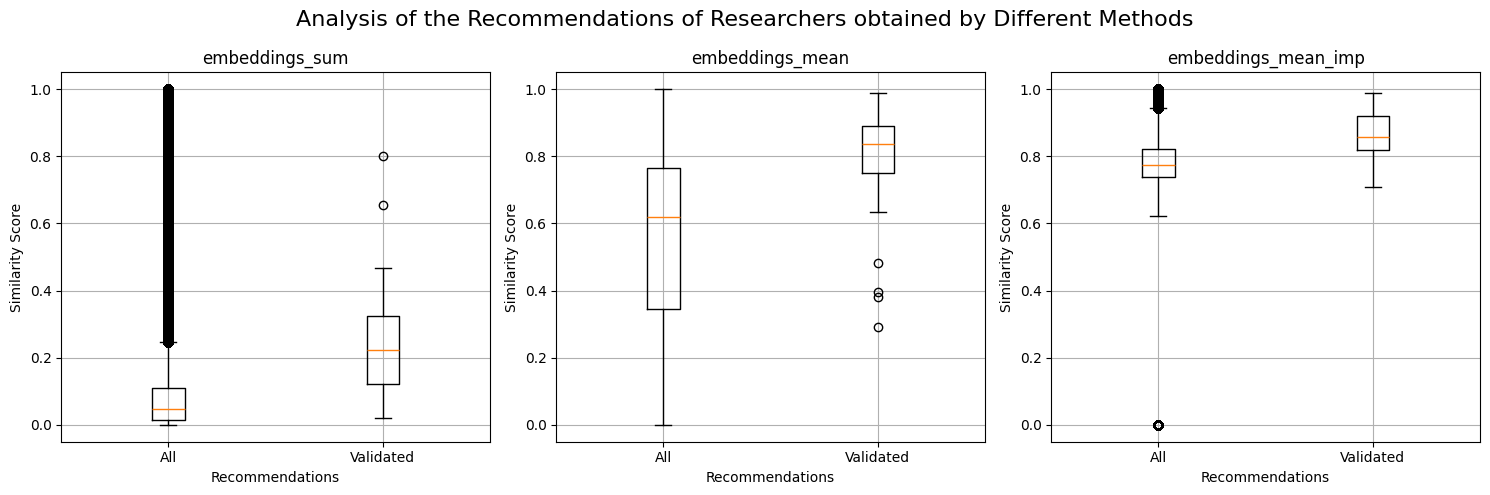

In [135]:
methods = ['BERT', 'tfidf', 'bhattacharyya', 'embeddings']
method = methods[3]
agg_methods = ['sum', 'mean', 'mean_imp'] 

recommendations = 'researchers'

fig, axs = plt.subplots(1, len(agg_methods), figsize=(15, 5))

for i, agg_method in enumerate(agg_methods):
    df_validation = val_results_researchers[f"{method}_{agg_method}_val_results"]    
    df_all_scores = get_sim_matrix_score(method=method, agg_method=agg_method, recommendations=recommendations)
    get_plot_scores_analysis_multiple(axs[i], df_all_scores, df_validation, method=method, agg_method=agg_method, recommendations=recommendations)

plt.suptitle('Analysis of the Recommendations of Researchers obtained by Different Methods', fontsize=16)
plt.tight_layout()
plt.show()